In [1]:
pip install keras_applications 

Note: you may need to restart the kernel to use updated packages.


In [10]:
import keras
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, MaxPool2D
from keras.layers.core import Lambda
from tensorflow.keras.utils import to_categorical
from keras.preprocessing import image
from tensorflow.keras import datasets, layers, models, losses
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tqdm import tqdm
%matplotlib inline
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import *
#from keras.utils import multi_gpu_model
from matplotlib import pyplot as plt
from keras.models import load_model
import keras.backend as K
from keras.layers.core import Lambda
from keras.applications.mobilenet_v2 import MobileNetV2
from keras.applications.inception_v3 import InceptionV3 
from keras.applications.densenet import DenseNet121
from keras.applications.vgg16 import VGG16
#from keras.applications.resnet50 import ResNet50
from keras_applications.resnet import ResNet50
from keras.applications.xception import Xception
from keras.applications.mobilenet import MobileNet
import os
from keras.layers import *

In [11]:
def Global_attention_block(inputs):
    shape=K.int_shape(inputs)
    
    x=tf.keras.layers.AveragePooling2D(pool_size=(shape[1],shape[2])) (inputs)
    x=Conv2D(shape[3],1, padding='same') (x)
    x=Activation('relu') (x)

    x=Conv2D(shape[3],1, padding='same') (x)
    x=Activation('sigmoid') (x)
    C_A=tf.keras.layers.Multiply()([x,inputs])
    
    x=Lambda(lambda x: K.mean(x,axis=-1,keepdims=True)) (C_A)
    x=Activation('sigmoid') (x)
    S_A=tf.keras.layers.Multiply()([x,C_A])
    return S_A

def Category_attention_block(inputs,classes,k):
    shape=K.int_shape(inputs)
    F=Conv2D(k*classes,1, padding='same') (inputs)
    F=tf.keras.layers.BatchNormalization() (F)
    F1=Activation('relu') (F)
    
    F2=F1
    x=tf.keras.layers.GlobalMaxPool2D()(F2)
    
    x=tf.keras.layers.Reshape((classes,k)) (x)
    S=Lambda(lambda x: K.mean(x,axis=-1,keepdims=False))  (x)
    
    x=tf.keras.layers.Reshape((shape[1],shape[2],classes,k)) (F1)
    x=Lambda(lambda x: K.mean(x,axis=-1,keepdims=False))  (x)
    x=tf.keras.layers.Multiply()([S,x])
    M=Lambda(lambda x: K.mean(x,axis=-1,keepdims=True))  (x)
    
    semantic=tf.keras.layers.Multiply()([inputs,M])
    return semantic

In [12]:
def smooth_curve(points, factor=0.6):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
    return smoothed_points    
   
def plotmodel(history,name):
    
    acc = history.history['acc']
    #val_acc = history.history['val_acc']
    loss = history.history['loss']
    #val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1) 
    
    plt.figure(1)                  
    plt.plot(epochs,smooth_curve(acc))
    #plt.plot(epochs,smooth_curve(val_acc))
    plt.ylabel('acc')
    plt.xlabel('epoch')
    #plt.legend(['train_acc', 'val_acc'], loc='upper left')
    plt.legend(['train_acc'], loc='upper left')
    plt.savefig('acc_'+name+'.png')
    
    plt.figure(2)
    plt.plot(epochs,smooth_curve(loss))
    #plt.plot(epochs,smooth_curve(val_loss))
    plt.ylabel('loss')
    plt.xlabel('epoch')
    #plt.legend(['train_loss', 'val_loss'], loc='upper right')
    plt.legend(['train_loss'], loc='upper right')
    plt.savefig('loss_'+name+'.png')

In [13]:
def get_base_model(model_name,image_size):
    if model_name =='vgg16':
        base_model=VGG16              (include_top=False,weights='imagenet',input_shape=(image_size,image_size,3))
    if model_name =='resnet50':
        base_model=ResNet50           (include_top=False,weights='imagenet',input_shape=(image_size,image_size,3))
    if model_name =='xception':
        base_model=Xception           (include_top=False, weights='imagenet',input_shape=(image_size,image_size,3))
    if model_name =='densenet121':    #done acc = 55% epochs:30
        base_model=DenseNet121       (include_top=False, weights='imagenet',input_shape=(image_size,image_size,3))
    if model_name =='mobilenet0.75': #acc = 60.41% loss = 1.21 epochs:70
        base_model=MobileNet         (include_top=False,weights='imagenet',alpha=0.75,input_shape=(image_size,image_size,3))
    if model_name =='mobilenet1.0': #acc = 60.41% loss = 1.21 epochs:70
        base_model=MobileNet         (include_top=False,weights='imagenet',alpha=1.0,input_shape=(image_size,image_size,3))
    if model_name =='mobilenetv2':
        base_model=MobileNetV2      (include_top=False,weights='imagenet',alpha=1.0,input_shape=(image_size,image_size,3))
    if model_name =='inceptionv3':   
        base_model=InceptionV3       (include_top=False,weights='imagenet',input_shape=(image_size,image_size,3))
    if model_name =='inceptionv2':
        base_model=InceptionResNetV2 (include_top=False, weights='imagenet',input_shape=(image_size,image_size,3))
    return base_model

In [14]:
def train_model(model,dataset,image_size,batch_size,save_name,lr1,lr2,Epochs1,Epochs2):
    
    dataParam={'messidor': [960,240,2,'Messidor_Binary_Classification/train',
                            'Messidor_Binary_Classification/test'],
               'kaggle': [30000,5126,5,'./data/kaggle/train','./data/kaggle/valid'],
               'DDR':   [9851,2503,5,'./data/DDR/train','./data/DDR/valid']} 
    
    train_num,valid_num,classes,train_dir,test_dir = dataParam[dataset]
    
    train=ImageDataGenerator(horizontal_flip=True,vertical_flip=True,rotation_range=90)          
    valid = ImageDataGenerator()
    train_data=train.flow_from_directory(train_dir,
                                         target_size=(image_size,image_size),
                                         shuffle = True,
                                         batch_size=batch_size)
    valid_data=valid.flow_from_directory(test_dir,
                                         target_size=(image_size,image_size),
                                         shuffle = False,
                                         batch_size=batch_size)

    lr_decay=ReduceLROnPlateau(monitor='loss', factor=0.8, patience=3, verbose=1)
    #save_model=ModelCheckpoint('new/'+save_name+'{epoch:02d}.h5', monitor='val_loss',period=10)
    
    filepath = "/Binary_save_weights/mobilenetv2_cab_messidor_weights.hdf5"
    checkpoint = ModelCheckpoint(filepath, monitor='acc',verbose=1, save_best_only=True, mode='max')

    for layer in base_model.layers:
        layer.trainable = False   
        
    model.compile(optimizer=tf.keras.optimizers.Adam(lr=lr1,decay=0.00001),loss=loss_fun,metrics=['acc'])
    model.fit(train_data,
                        steps_per_epoch=train_num/batch_size,
                        epochs=Epochs1, 
                        workers=2,
                        callbacks=[lr_decay,checkpoint])   
    
    for layer in base_model.layers:
        layer.trainable = True
        
    model.compile(optimizer=tf.keras.optimizers.Adam(lr=lr2,decay=0.00001),loss=loss_fun,metrics=['acc'])
    history=model.fit(train_data,
                        steps_per_epoch=train_num/batch_size,
                        epochs=Epochs2,
                        workers=2,
                        callbacks=[lr_decay,checkpoint])
    
    score = model.evaluate(valid_data,batch_size = 16)
    print('Test loss:', score[0])
    print('Test accuracy:', score[1])
    
    return history,model,valid_data

In [16]:
os.environ["CUDA_VISIBLE_DEVICES"] = "4"    
loss_fun= 'categorical_crossentropy'  
gpu_num=1
k=5
lr1=0.005
lr2=0.0001
batch_size= 4
image_size=224
classes=2

base_model=get_base_model('mobilenetv2',image_size)  
base_in=base_model.input
base_out=base_model.output

x=Global_attention_block(base_out)
base_out=Category_attention_block(x,classes,k)

shape=K.int_shape(base_out)  
x=GlobalAveragePooling2D()(base_out)
out=Dense(classes,activation='softmax')(x)

parallel_model=keras.Model(base_model.input,out)
    
history,model,valid_data=train_model(parallel_model,
                                     'messidor',
                                     image_size,
                                     batch_size,
                                     'mobilenetv2',
                                     lr1,lr2,1,70)

Found 960 images belonging to 2 classes.
Found 240 images belonging to 2 classes.
240/240 [==============================] - ETA: 0s - loss: 0.6963 - acc: 0.5844
Epoch 00001: acc improved from -inf to 0.58438, saving model to /Binary_save_weights\mobilenetv2_cab_messidor_weights.hdf5
240/240 [==============================] - 70s 291ms/step - loss: 0.6963 - acc: 0.5844
Epoch 1/70
240/240 [==============================] - ETA: 0s - loss: 0.6697 - acc: 0.5844
Epoch 00001: acc did not improve from 0.58438
240/240 [==============================] - 393s 2s/step - loss: 0.6697 - acc: 0.5844
Epoch 2/70
240/240 [==============================] - ETA: 0s - loss: 0.6618 - acc: 0.5948
Epoch 00002: acc improved from 0.58438 to 0.59479, saving model to /Binary_save_weights\mobilenetv2_cab_messidor_weights.hdf5
240/240 [==============================] - 380s 2s/step - loss: 0.6618 - acc: 0.5948
Epoch 3/70
240/240 [==============================] - ETA: 0s - loss: 0.6283 - acc: 0.6417
Epoch 00003: 

240/240 [==============================] - ETA: 0s - loss: 0.3267 - acc: 0.8646
Epoch 00029: acc did not improve from 0.87604
240/240 [==============================] - 345s 1s/step - loss: 0.3267 - acc: 0.8646
Epoch 30/70
240/240 [==============================] - ETA: 0s - loss: 0.3322 - acc: 0.8531
Epoch 00030: acc did not improve from 0.87604
240/240 [==============================] - 344s 1s/step - loss: 0.3322 - acc: 0.8531
Epoch 31/70
240/240 [==============================] - ETA: 0s - loss: 0.3160 - acc: 0.8708
Epoch 00031: ReduceLROnPlateau reducing learning rate to 6.399999838322402e-05.

Epoch 00031: acc did not improve from 0.87604
240/240 [==============================] - 350s 1s/step - loss: 0.3160 - acc: 0.8708
Epoch 32/70
240/240 [==============================] - ETA: 0s - loss: 0.2982 - acc: 0.8719
Epoch 00032: acc did not improve from 0.87604
240/240 [==============================] - 417s 2s/step - loss: 0.2982 - acc: 0.8719
Epoch 33/70
240/240 [==================

Epoch 61/70
240/240 [==============================] - ETA: 0s - loss: 0.1379 - acc: 0.9385
Epoch 00061: acc did not improve from 0.94479
240/240 [==============================] - 343s 1s/step - loss: 0.1379 - acc: 0.9385
Epoch 62/70
240/240 [==============================] - ETA: 0s - loss: 0.1153 - acc: 0.9583
Epoch 00062: acc improved from 0.94479 to 0.95833, saving model to /Binary_save_weights\mobilenetv2_cab_messidor_weights.hdf5
240/240 [==============================] - 340s 1s/step - loss: 0.1153 - acc: 0.9583
Epoch 63/70
240/240 [==============================] - ETA: 0s - loss: 0.1098 - acc: 0.9552
Epoch 00063: acc did not improve from 0.95833
240/240 [==============================] - 336s 1s/step - loss: 0.1098 - acc: 0.9552
Epoch 64/70
240/240 [==============================] - ETA: 0s - loss: 0.1146 - acc: 0.9542
Epoch 00064: acc did not improve from 0.95833
240/240 [==============================] - 330s 1s/step - loss: 0.1146 - acc: 0.9542
Epoch 65/70
240/240 [=======

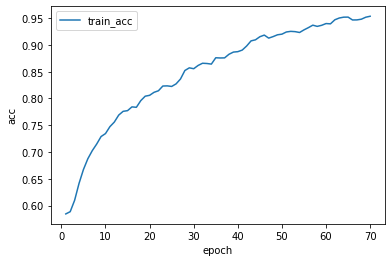

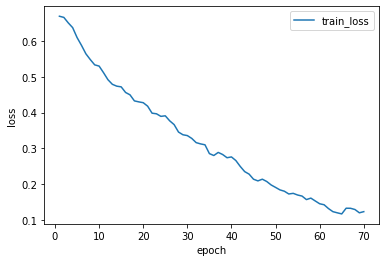

In [17]:
plotmodel(history,'mobilenetv2')         

In [18]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sn

Y_pred = model.predict(valid_data, 240 // 4)
#print(Y_pred.shape)
#print(type(Y_pred))
print(valid_data.classes)  
print(Y_pred)
y_pred = np.argmax(Y_pred, axis=1)
#print(y_pred)
print('Confusion Matrix')
matrix = confusion_matrix(valid_data.classes, y_pred)

print(confusion_matrix(valid_data.classes, y_pred))
print('Classification Report')
target_names = ['non-referable', 'referable']
print(classification_report(valid_data.classes, y_pred, target_names=target_names))

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
[[9.06134605e-01 9.38653722e-02]
 [5.49222634e-04 9.99450743e-01]
 [9.99997139e-01 2.84703674e-06]
 [7.60193706e-01 2.39806280e-01]
 [7.51780629e-01 2.48219401e-01]
 [1.96487010e-02 9.80351269e-01]
 [7.74117351e-01 2.25882709e-01]
 [9.98128831e-01 1.87123357e-03]
 [6.72541678e-01 3.27458322e-01]
 [9.89995480e-01 1.00045465e-02]
 [9.95340347e-01 4.65961685e-03]
 [9.98783648e-01 1.21641357e-03]
 [3.29242011e-09 1.00000000e+00]
 [9.86807883e-01 1.31921209e-02]
 [2.22847834e-01 7.77152121e-01]
 [7.06930533e-02 

In [ ]:
plt.figure(figsize = (10,7))
sn.heatmap(matrix,annot=True,fmt='d')
plt.xlabel('Predicted value')
plt.ylabel('Truth')   